# Lesson 6: Metaprompting with o1

Optimizing to production is one of the biggest painpoints we've seen developers experience with working with LLMs - with so much guidance for prompt engineering, RAG and fine-tuning out there, figuring out which optimization you need to hill-climb on your evals can be a difficult problem to frame and solve.

Luckily, it appears to be one of the use cases that `o1` is capable at. In this session we'll focus on how to use `o1-mini` to work with a set of evals to optimize our prompt for the task and improve score on our evals.


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

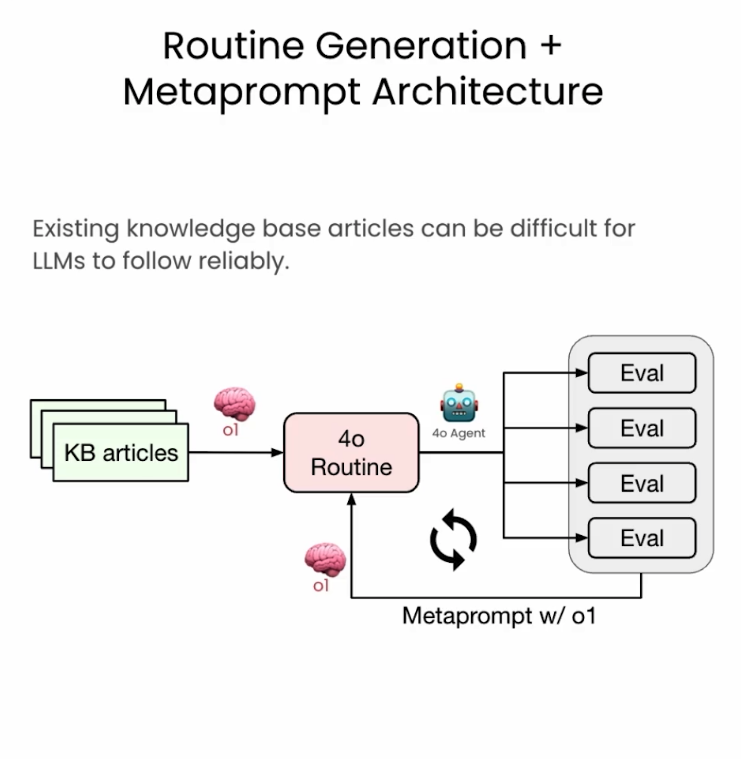

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Import OpenAI key
from helper import get_openai_api_key
openai_api_key = get_openai_api_key()

In [ ]:
from openai import OpenAI
from IPython.display import display, Markdown
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functionDefinitions import TOOLS
import csv
import json
import os
import matplotlib.pyplot as plt

GPT_MODEL = 'gpt-4o-mini'
O1_MODEL = 'o1'

client = OpenAI(api_key=openai_api_key)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
from redlines import Redlines
from IPython.display import display, Markdown

def compare_strings(string1, string2):
    # Create a Redlines object to compare the strings
    diff = Redlines(string1, string2)
    
    # Display the differences using Markdown
    display(Markdown(diff.output_markdown))

# Example usage
string_a = "This is the original text for comparison purposes."
string_b = "This is the modified text to compare for differences."

compare_strings(string_a, string_b)

## Step 1: Generate 4o routine (prompt)

We'll take the Flight Cancellation Policy that we have created and convert it to an LLM-based routine with the following prompt.

This process is also a good use of O1, using a purely text document to create instructions and tools for an LLM to make use of. To dive deeper on this topic check out [this cookbook](https://cookbook.openai.com/examples/o1/using_reasoning_for_routine_generation).

In [ ]:
with open('originalPolicy/flightCancellationsPolicy.md', 'r') as file:
    flight_cancellation_policy = file.read()
    print(flight_cancellation_policy)

In [ ]:
CONVERSION_PROMPT = f"""
You are a helpful assistant tasked with taking an external facing help center article and converting it into a internal-facing programmatically executable routine optimized for an LLM. 
The LLM using this routine will be tasked with reading the policy, answering incoming questions from customers, and helping drive the case toward resolution.

Please follow these instructions:
1. **Review the customer service policy carefully** to ensure every step is accounted for. It is crucial not to skip any steps or policies.
2. **Organize the instructions into a logical, step-by-step order**, using the specified format. 
3. **Use the following format**:
   - **Main actions are numbered** (e.g., 1, 2, 3).
   - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
      **Sub-actions should start on new lines**
   - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
   - **For instructions that require more information from the customer**, provide polite and professional prompts to ask for additional information.
   - **For actions that require data from external systems**, write a step to call a function using backticks for the function name (e.g., call the `check_delivery_date` function).
      - **If a step requires the customer service agent to take an action** (e.g., process a refund), generate a function call for this action (e.g., call the `process_refund` function).
      - **Only use the available set of functions that are defined below.
   - **If there is an action an assistant can perform on behalf of the user**, include a function call for this action (e.g., call the `change_email_address` function), and ensure the function is defined with its purpose and required parameters.
      - **Only use the available set of functions that are defined below.
   - **The step prior to case resolution should always be to ask if there is anything more you can assist with**.
   - **End with a final action for case resolution**: calling the `case_resolution` function should always be the final step.
4. **Ensure compliance** by making sure all steps adhere to company policies, privacy regulations, and legal requirements.
5. **Handle exceptions or escalations** by specifying steps for scenarios that fall outside the standard policy.
6. **Ensure coverage** by checking that all of the conditions covered in the policy are also covered in the routines

**Important**: Always wrap the functions you return in backticks i.e. `check_ticket_type`. Do not include the arguments to the functions.

Here are the currently available set of functions in JSON format: 
TOOLS: {TOOLS}

Please convert the following customer service policy into the formatted routine, ensuring it is easy to follow and execute programmatically. Ensure that you **only** use the functions provided and do **not** create net new functions."""

In [ ]:
def generate_routine(policy):
    try:
        messages = [
            {
                "role": "user",
                "content": f"""
                    {CONVERSION_PROMPT}

                    POLICY:
                    {policy}
                """
            }
        ]

        response = client.chat.completions.create(
            model='o1-mini',
            messages=messages
        )
        

        return response.choices[0].message.content 
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
flight_cancellation_routine = generate_routine(flight_cancellation_policy)

In [ ]:
display(Markdown(flight_cancellation_routine))

### Data quality check

We'll check that `o1-mini` has followed our instructions and used only the functions we provided.

If it added additional ones, we'll need to write functions for them before proceeding.

In [ ]:
import re
from collections import Counter

def compare_lists(a, b):
    # Create Counters for both lists
    counter_a = Counter(a)
    counter_b = Counter(b)
    
    # Find elements that are only in A or have a higher count in A
    diff_a = counter_a - counter_b
    # Find elements that are only in B or have a higher count in B
    diff_b = counter_b - counter_a
    
    # Report differences
    print("Items in A that are not in B (or more of in A):")
    for item, count in diff_a.items():
        print(f"{item}: {count}")

    print("\nItems in B that are not in A (or more of in B):")
    for item, count in diff_b.items():
        print(f"{item}: {count}")

def extract_function_names(text):
    # Use regex to match text between backticks and extract function names
    pattern = r'`(.*?)`'
    matches = re.findall(pattern, text)
    return matches

# Extract a unique list of the functions in the generated routine
function_names_from_o1 = set(extract_function_names(flight_cancellation_routine))

# Extract the list of TOOLs we provided the model
function_names_defined = [tool["function"]["name"] for tool in TOOLS if tool["type"] == "function"]

# Print the differences
## Items that are in A and not in B need functions written for them
## Items that are in B and not in A are fine, they are just unused in the routine the model has written
compare_lists(function_names_from_o1, function_names_defined)

## Step 2: Evaluation

Now that we have a routine generated with o1, we can run it against our evaluation suite and measure its accuracy.

We'll start by creating an agent that is equipped with the policy and a list of tools. It will be given messages from an existing conversation and will be tasked with determining the next best action to take

In [ ]:
def agent_response(transcript, policy, model):
    try:
        messages = [
            {
                "role": "system",
                "content": f"""
You are a customer service agent that is responsible for handling airline related issues. Below is the exact policy that you must follow to address the customer's issue.

POLICY:
{policy}
                """
            }
        ]

        messages.extend(transcript)
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=TOOLS,
            parallel_tool_calls=False,
        temperature=0)
        
        return response.choices[0].message 
    except Exception as e:
        print(f"An error occurred: {e}")
        print(messages)

We will process each row in parallel to reduce runtime and compare the function call + inputs that the model selects against our expected function + parameters.

In [ ]:
import math 

def safe_str(value):
    return "" if (isinstance(value, float) and math.isnan(value)) else str(value)

def process_row(row_number,test_row,policy,model,iteration=0, verbose=False):
    # Extract variables from test_row
    context = test_row['context']
    request = test_row['request']
    full_name = test_row['full_name']
    booking_ref = test_row['booking_ref']
    flight_no = test_row['flight_no']
    ticket_type = test_row['ticket_type']
    fare_rules = safe_str(test_row['fare_rules'])
    medical_certificate = safe_str(test_row['medical_certificate'])
    refund_amount = safe_str(test_row['refund_amount'])
    expected_function = test_row['expected_function']
    expected_inputs_str = test_row['expected_inputs']
    expected_inputs = json.loads(expected_inputs_str)

    CUSTOMER_PROMPT = f"""<objective>You are a customer named {full_name} trying to resolve an issue with a customer service agent.
    Continue providing the information the agent requests so they can solve your issue.
    If you have the information in your *details* then use that. Otherwise, generate an appropriate answer.</objective>
    <details>
    Booking Reference: {booking_ref}
    Flight Number: {flight_no}
    {f"Medical Reference: {medical_certificate}" if medical_certificate else ""}
    Context: {context}
    Your initial request: {request}
    </details>
    <guidance>
    Remember that YOU are the customer.
    If the agent needs some information, that must come from you. 
    Do not ask the agent for information.
    </guidance>
    """

    # Initialize transcript
    transcript = [{"role": "user", "content": request}]
    if verbose:
        print(f'Starting request: {request}')
    
    # Initialize variables
    is_correct = False

    loop_count = 0
    while True:
        loop_count += 1
        if loop_count > 10:
            actual_function = None
            actual_inputs = None
            break
        # Call agent_response with the current transcript, policy, model
        response = agent_response(transcript, policy, GPT_MODEL)
        
        # Extract assistant message content and tool_calls
        if response:
            assistant_message_content = response.content
            tool_calls = response.tool_calls
        else:
            assistant_message_content = None
            tool_calls = None
        
        if not tool_calls:
            # Append assistant's message to transcript
            transcript.append({"role": "assistant", "content": assistant_message_content})
            
            # Get customer response
            customer_messages = [{"role": "system", "content": CUSTOMER_PROMPT}]
            customer_messages.extend(transcript)
            
            customer_response = client.chat.completions.create(model=GPT_MODEL, messages=customer_messages)
            
            # Append customer response to transcript
            transcript.append({"role": "user", "content": customer_response.choices[0].message.content})
            
            # Continue the loop
            continue
        else:
            #print(tool_calls)
            # There is a tool call
            tool_call = tool_calls[0]  # Assuming we're only interested in the first tool call
            function_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
            
            if function_name == 'verify_identity':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # Simulate the tool response
                tool_response = "True"
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'ask_clarification':
                # Take the 'prompt' from arguments and use it as assistant message
                clarification_prompt = arguments.get('prompt')
                
                # Append assistant's clarification message
                transcript.append({"role": "assistant", "content": clarification_prompt})
                
                # Get customer response
                customer_messages = [{"role": "system", "content": CUSTOMER_PROMPT}]
                customer_messages.extend(transcript)
                
                customer_response = client.chat.completions.create(model=GPT_MODEL, messages=customer_messages)
                
                # Append customer response to transcript
                transcript.append({"role": "user", "content": customer_response.choices[0].message.content})
                
                # Continue the loop
                continue
            elif function_name == 'check_ticket_type':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Ticket type: {ticket_type}\nFare rules: {fare_rules}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'check_fare_rules':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Ticket type: {ticket_type}\nFare rules: {fare_rules}'

                if fare_rules == 'partial_refund':
                    tool_response += f'\nRefund amount: {refund_amount}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'get_refund_amount':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Refund amount: {refund_amount}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'check_next_available_flight':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # simulating the tool response
                tool_response = f'Next available flight: LMG091 at 10:00 AM Tomorrow'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'provide_alternative_options':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # simulating the tool response
                tool_response = f'Next available flight: FR9876 at 5:00 PM Tomorrow'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            else:
                if verbose:
                    print('Got a successful function call')
                # Stop and compare function call and arguments with expected_function and expected_inputs
                transcript.append(response)
                actual_function = function_name
                actual_inputs = arguments
                is_correct = (actual_function == expected_function) and (str(actual_inputs) == str(expected_inputs))
                
                # Break the loop
                break
    
    # Return the results
    return {
        'request': request,
        'context': context,
        'expected_function': expected_function,
        'expected_inputs': expected_inputs,
        'actual_function': actual_function,
        'actual_inputs': actual_inputs,
        'is_correct': is_correct,
        'transcript': transcript
    }

# added post-filming to address transcript size
def filter_messages(message_list):
    messages = []
    for item in message_list:
        # Convert the item to a string and check if 'ChatCompletionMessage' is in it.
        if 'ChatCompletionMessage' in str(item):
            #print(item)
            message = {"role": "assistant",
                       "tool_call": {
                           "name": item.tool_calls[0].function.name,
                           "arguments": item.tool_calls[0].function.arguments
                       }
                      }
            messages.append(message)
        else:
            messages.append(item)
    return messages


def evaluate_function_calls(df, policy, model, i=0, verbose=False):
    records = []

    # Use ThreadPoolExecutor to process rows in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_row, row_number, row, policy, model, i, verbose): row_number for row_number, row in df.iterrows()}
        for future in futures:
            record = future.result()
            records.append(record)


    df = pd.DataFrame(records)
    df['cleaned_transcript'] = df['transcript'].apply(filter_messages)
    total_accuracy = df['is_correct'].mean()
    return df, total_accuracy

Let's take a look at the results

In [ ]:
eval_df = pd.read_csv('evals/policyEvals.csv')
eval_df.head()

In [ ]:
from termcolor import colored

def display_row(index):
    eval_row = eval_df.iloc[index]
    df_row = df.iloc[index][["actual_function", "actual_inputs", "is_correct", "cleaned_transcript"]]
    transcript_list = df_row["cleaned_transcript"]

    print("Eval DataFrame Row:")
    print(eval_row)
    print("\nDataFrame Columns:")
    print("actual_function:", df_row["actual_function"])
    print("actual_inputs:", df_row["actual_inputs"])
    print("is_correct:", df_row["is_correct"])
    print("transcript:")
    for entry in transcript_list:
        role = entry["role"] if isinstance(entry, dict) else getattr(entry, "role", None)
        color = "blue" if role == "user" else "red"
        print(colored(str(entry), color))


In [ ]:
df, accuracy = evaluate_function_calls(eval_df, flight_cancellation_routine, GPT_MODEL)

# Display the accuracy as a mini header
display(Markdown(f"### Accuracy: {accuracy:.2%}"))

display(df)

In [ ]:
display_row(8)

## Step 3: Improve 4o routine

Let's now leverage o1 again to add in a metaprompting loop to see if we can improve the quality of our evals.

We'll take the following multi-step approach:
- We'll pass in the current routine + eval results to o1 and ask it analyze the results and update the routine accordingly
- Since o1 does not currently support structured outputs, we'll chain with output with a 4o to enforce a schema we can parse
- Finally, we take the new routine and run it back through our eval to generate new results

We'll run this loop a fixed number of times and see what improvements we can make

In [ ]:
def get_openai_response(messages, model, response_format=None):
    try:
        if response_format:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                response_format={"type": "json_schema", "json_schema": response_format}
            )
        else:
            response = client.chat.completions.create(
                model=model,
                messages=messages
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")


OUTPUT_SCHEMA = {
                    "name": "policy_output",
                    "schema": {
                    "type": "object",
                    "properties": {
                        "final_answer": { "type": "string" }
                    },
                    "required": ["final_answer"],
                    "additionalProperties": False
                    },
                    "strict": True
                }

In [ ]:
start_o1_message = [
    {
        "role": "user",
        "content": f"""# Instructions
You are an agent that is responsible for improving the quality of instructions that are provided to a customer service LLM agent. 
Your task is to improve the instructions that are provided to the LLM agent in order to increase accuracy on a test set while adhering to the initial policy. 

## Criteria
- Analyze the existing instructions and the results of the eval. Understand which behaviors lead to failures.
- For example, if the LLM agent is not asking for the booking reference when it is needed, you should add a step to ask for the booking reference.
- Improve the instructions to address the gaps in the eval results.
- Ensure changes made are compliant with the original policy.
- Only use the tools provided.
- Use the functions provided to the best of your ability to ensure the LLM agent can handle the customer service requests effectively. Including gathering data where necessary.
- Try changing the format if this formatting doesn't work well - consider basic XML (e.g. <step> <substep> <if> <case>) or markdown as alternatives.

You will be provided with 4 items:
1) The ground-truth policy for the customer service agent containing detailed instructions on how to handle flight cancellations and changes.
2) Full list of available functions.
3) A routine instruction set.
4) A results that shows the LLMs performance on a test set using this routine instruction set. This dataset contains columns showing:
    - request: This is the initial user request. 
    - expected_function: This is the function we expect the LLM to call at the end of the conversation. 
    - expected_input: This is the input we expect the LLM to provide to the function at the end of the conversation.
    - actual_function: This is the final function the LLM called using the current instructions.
    - actual_input: These are the function parameters the LLM provided based on the current instructions.
    - transcript: This is the conversation transcript between the user and the LLM agent. 
    - is_correct: True/False value depending on if the model responded correctly

You may be provided with a history of edits and evaluations. You can use this information to understand what has been tried before and what has worked or not worked.

# Data

## 1. Original policy
{flight_cancellation_policy}

## 2. Functions
{TOOLS}

# Conclusion

Return the improved policy exactly as written within the defined JSON. Remove all parts from the LLM's answer that are not part of the policy, and do not create additional keys.
"""
     }
]

In [ ]:
import tiktoken 

encoding = tiktoken.get_encoding("o200k_base")

def num_tokens_from_messages(messages):
    entire_input = ""
    for message in messages:
        entire_input += message["content"] + " "
    tokens = encoding.encode(entire_input)
    return len(tokens)

When improving the routine, consider these approaches:
- Adding synthetic examples to show the model how to choose between two commonly mistaken functions
- Given it general guidance on what attributes to look out for which it commonly mislabels
- Being more specific with your guidance on how to follow the routine.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>High Token Warning!:</b> Running the following cell consumes many tokens. Running multiple times may result in a message regarding exceeding a monthy quota.</p>

In [ ]:
# start with data from first run
routines = [flight_cancellation_routine]
results = [df]
accuracies = [round(accuracy * 100, 2)]
o1_messages = start_o1_message.copy()

MAX_TOKENS = 120000

for i in range(3):
    display(Markdown(f"## Iteration {i+1}"))
    
    # Build a candidate message with the most recent eval (full table)
    prev_results = results[-1]
    pf = prev_results.drop(columns=['transcript'])

    new_eval_content = (
        f"## 3. Routine instructions:\n"
        f"{routines[-1]}\n"
        f"## 4. Results table:\n"
        f"{pf.to_json(orient='records')}\n"
    )
    
    # Check token count before adding the newest eval
    candidate_messages = o1_messages + [{"role": "user", "content": new_eval_content}]
    if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
        o1_messages.append({"role":"user", "content": new_eval_content})
    else:
        # If we can't even fit the newest eval, consider truncation or error handling
        # For simplicity, we skip truncation logic here
        print("excluding eval content {num_tokens_from_messages(candidate_messages)}")
        pass

    print(f"num tokens {num_tokens_from_messages(o1_messages)}")
    print(f"len messages {len(o1_messages)}")


    # Get the updated routine from the metaprompting assistant
    temp_routine_json = get_openai_response(o1_messages
                                            , O1_MODEL
                                            ,response_format=OUTPUT_SCHEMA)
    #temp_routine_str = temp_routine_json.strip("json```").strip("```")
    new_routine = json.loads(temp_routine_json)["final_answer"]
    routines.append(new_routine)

    eval_df = pd.read_csv('evals/policyEvals.csv')

    # Evaluate the function calls with the current policy on the gpt-4o model
    eval_df, accuracy = evaluate_function_calls(
        eval_df,
        new_routine,
        GPT_MODEL,
        i
    )
    accuracies.append(round(accuracy * 100, 2))
    results.append(eval_df)
    display(Markdown(f"### Accuracy: {accuracy:.2%}"))

    #list the IDs of the failed rows
    failed_ids = eval_df[eval_df['is_correct'] == False].index.tolist()
    display(eval_df.loc[failed_ids])
    eval_df.to_csv(f'evals/results_run_{i+1}.csv', index=False)

    # Instantiate fresh o1 message
    o1_messages = start_o1_message.copy()

    # Attempt to include older examples (omitting 'transcript') within token limit
    older_results = results[:-1][::-1]  # all except the newest, reversed for most recent first
    for old_eval_df in older_results:
        if 'transcript' in old_eval_df.columns:
            truncated_df = old_eval_df.drop(columns=['transcript','cleaned_transcript'])
        else:
            truncated_df = old_eval_df

        old_content = "## Older eval (no transcript):\n" + truncated_df.to_json(orient='records')
        candidate_messages = o1_messages + [{"role": "user", "content": old_content}]
        if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
            o1_messages.append({"role": "user", "content": old_content})
        else:
            # If we exceed token limits, stop adding older examples
            break


In [ ]:
# Plot accuracy over runs
plt.plot(range(1,len(accuracies)+1), accuracies, marker='o')
plt.title('Accuracy over time')
plt.xlabel('Run number')
plt.ylabel('Accuracy')
plt.savefig('metaprompt_accuracy.png')
plt.show()


In [ ]:
# Print best routine
best_routine = routines[accuracies.index(max(accuracies))]
display(Markdown(f"## Best Routine\n{best_routine}"))

In [ ]:
routines[accuracies.index(max(accuracies))]